# intakeOutput

Intake and output recorded for patients. Entered from the nursing flowsheet (either manually or interfaced into the hospital system).

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [3]:
patientunitstayid = 242380

In [8]:
query = query_schema + """
select *
from intakeoutput
where patientunitstayid = {}
order by intakeoutputoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,patientunitstayid,intakeoutputid,intakeoutputyear,intakeoutputtime24,intakeoutputtime,intakeoutputoffset,intaketotal,outputtotal,dialysistotal,nettotal,intakeoutputentryyear,intakeoutputentrytime24,intakeoutputentrytime,intakeoutputentryoffset,cellpath,celllabel,cellvaluenumeric,cellvaluetext
0,242380,17914026,2015,11:00:00,noon,-181,0.0,650.0,0.0,-650.0,2015,16:08:18,evening,127,flowsheet|Flowsheet Cell Labels|I&O|Weight|Bod...,Bodyweight (lb),269.0,269
1,242380,17914024,2015,11:00:00,noon,-181,0.0,650.0,0.0,-650.0,2015,16:08:18,evening,127,flowsheet|Flowsheet Cell Labels|I&O|Output (ml...,Urine,650.0,650
2,242380,17914025,2015,11:00:00,noon,-181,0.0,650.0,0.0,-650.0,2015,16:08:18,evening,127,flowsheet|Flowsheet Cell Labels|I&O|Weight|Bod...,Bodyweight (kg),122.0,122
3,242380,17609931,2015,19:00:00,night,299,0.0,500.0,0.0,-500.0,2015,21:01:57,night,420,flowsheet|Flowsheet Cell Labels|I&O|Output (ml...,Urine,500.0,500
4,242380,18175773,2015,03:00:00,morning,779,0.0,700.0,0.0,-700.0,2015,07:54:33,midday,1073,flowsheet|Flowsheet Cell Labels|I&O|Output (ml...,Urine,700.0,700


Above we can see that the type of data recorded is described by the `cellpath`. `cellpath` is hierarchical, with pipes (`|`) separating hierarchies. As expected, most data here will fall under the I&O hierarchy. We can see the patient body weight is recorded in both pounds (lbs) and kilograms (kg). The patient's urine output is also documented.

### Urine output

Though not recommended for actual use in a study, we can write a query to quickly get an idea of urine output for this patient.

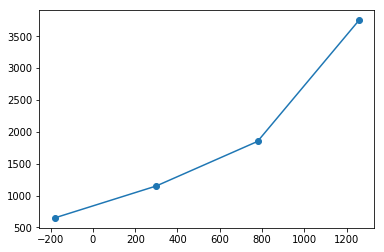

In [14]:
df_uo = df.loc[df['celllabel'].str.contains('Urine'), :].copy()
df_uo['uo'] = pd.to_numeric(df_uo['cellvaluenumeric'], errors='coerce')
df_uo['uo'] = df_uo['uo'].cumsum()
plt.figure()
plt.plot(df_uo['intakeoutputoffset'], df_uo['uo'], 'o-')
plt.show()

## General intake/output

The columns `intaketotal`, `outputtotal`, `dialysistotal`, and `nettotal` give us an easy way to plot the patient's fluid balance over time.

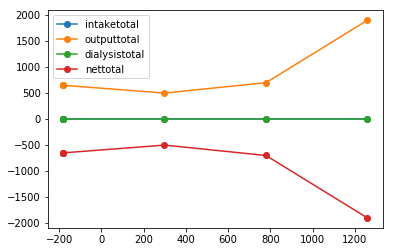

In [16]:
plt.figure()
for c in ['intaketotal', 'outputtotal', 'dialysistotal', 'nettotal']:
    plt.plot(df['intakeoutputoffset'], df[c], 'o-')
plt.legend(loc='upper left')
plt.show()

Of course, it is unlikely that the patient has good urine output for almost 20 hours with no corresponding fluid intake - and even less likely that urine output is the *only* factor affecting patient fluid balance and likely the `nettotal` column is a naive aggregation of information documented in the intakeOutput table. Indeed, we can see from the infusionDrug table that the patient is receiving both heparin and nitroglycerin, which should be factored in as inputs when calculating patient fluid balance.

## Hospitals with data available

In [18]:
query = query_schema + """
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct a.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join intakeoutput a
  on pt.patientunitstayid = a.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6914,97.945885
54,167,6092,5666,93.007223
106,264,5237,5088,97.154860
184,420,4679,4446,95.020303
134,338,4277,4232,98.947861
90,243,4243,4156,97.949564
71,199,4240,3970,93.632075
58,176,4328,3935,90.919593
206,458,3701,3663,98.973250
122,300,3617,3534,97.705281


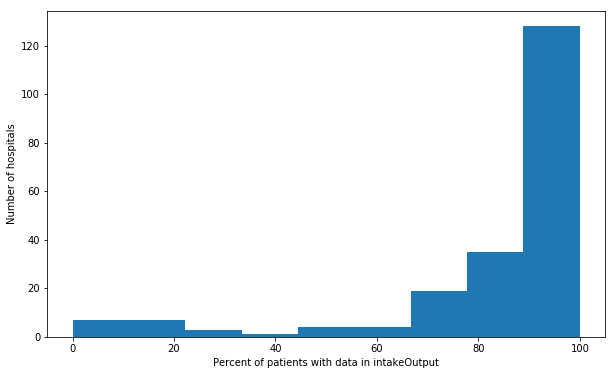

In [20]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in intakeOutput')
plt.ylabel('Number of hospitals')
plt.show()

Above we can see that around 10 hospitals have very few to no patients documented in the intakeOutput table (left side of histogram, 0-10% bin), while over 120 hospitals have 90-100% of patients with data in intakeOutput (right side of histogram, 0-90% bin). 